In [0]:
from PIL import Image
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import torchvision
from torchvision import transforms
from torchvision import models
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sn
# !pip install torchsummary 
# import torchsummary

In [2]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.20.5 (Git Hash 0125f28c61c1f822fd48570b4c1066f96fcb9b2e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_37,code=compute_37
  - CuDNN 7.6.3
  - Magma 2.5.1
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variabl

In [3]:
torch.get_num_threads()

2

In [0]:
torch.set_num_threads(4)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

KeyboardInterrupt: ignored

In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/kaggle/train.csv')
df_test = pd.read_csv('/content/gdrive/My Drive/kaggle/test.csv')
df_class = pd.read_csv('/content/gdrive/My Drive/kaggle/class_map.csv')
df_submission = pd.read_csv('/content/gdrive/My Drive/kaggle/sample_submission.csv')

In [0]:
def make_tensordataset_from_dfs(parquet_locs, label_loc=None):
    ids = []
    X = []
#     parquet_locs = notebook.tqdm(parquet_locs)
    for parquet_loc in parquet_locs:
        df = pd.read_parquet(parquet_loc)
        ids.extend(df.image_id.tolist())
        x = df.iloc[:, 1:].to_numpy(dtype=np.uint8)
        del df
        X.append(x)
    X = np.vstack(X)
    X = X.reshape(-1, 1, 137, 236)
    X = torch.from_numpy(X)
    ids = dict((s,i) for (i,s) in enumerate(ids))
    if label_loc is None:
        return TensorDataset(X)
    else:
        graphemes = torch.zeros(X.shape[0], dtype=torch.long)
        vowel_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        consonant_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        lbl_df = pd.read_csv(label_loc)
        for row in lbl_df.itertuples():
            if row.image_id not in ids:
                continue
            idx = ids[row.image_id]
            graphemes[idx] = row.grapheme_root
            vowel_diacs[idx] = row.vowel_diacritic
            consonant_diacs[idx] = row.consonant_diacritic
        return TensorDataset(X, graphemes, vowel_diacs, consonant_diacs)

In [0]:
ds = make_tensordataset_from_dfs(['/content/gdrive/My Drive/kaggle/train_image_data_{}.parquet'.format(i) for i in range(4)], '/content/gdrive/My Drive/kaggle/train.csv')

(tensor(72),
 tensor(4),
 tensor(0),
 tensor(255, dtype=torch.uint8),
 tensor(34, dtype=torch.uint8))

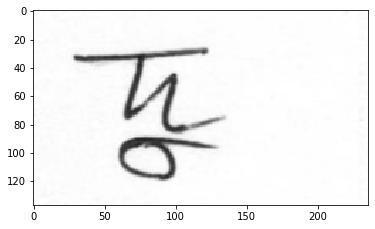

In [13]:
plt.imshow(ds[100000][0].permute(1, 2, 0).reshape(137, 236), cmap='gray', vmin=0, vmax=255)
ds[100000][1], ds[100000][2], ds[100000][3], ds[100000][0].max(), ds[100000][0].min()

In [0]:
tr_indices, va_indices = train_test_split(list(range(len(ds))), test_size=.1, train_size=.9, random_state=42)#, stratify=ds.tensors[1])

In [0]:
tr_ds = Subset(ds, tr_indices)
va_ds = Subset(ds, va_indices)

In [16]:
len(ds), len(tr_ds), len(va_ds)

(200840, 180756, 20084)

In [0]:
n_graphemes, n_vowel_diacs, n_consonant_diacs = len(set(df_train['grapheme_root'])), len(set(df_train['vowel_diacritic'])), len(set(df_train['consonant_diacritic']))

In [0]:
def make_linear_block(in_size, out_size):
    block = nn.Sequential(
        nn.Linear(in_size, out_size),
        nn.ReLU(), 
        nn.BatchNorm1d(num_features=out_size),
        nn.Dropout(0.1)
    )
    nn.init.xavier_normal_(block[0].weight.data)
    nn.init.zeros_(block[0].bias.data)
    return block

def make_ff_predictor(in_size, intermediate_size, out_size, layer_count):
    layers = [make_linear_block(in_size, intermediate_size)]
    for i in range(layer_count):
        layers.append(make_linear_block(intermediate_size, intermediate_size))
    layers.append(make_linear_block(intermediate_size, out_size))
    layers = nn.Sequential(*layers)
    return layers

class BanglaHandwrittenGraphemeNN(nn.Module):
    def __init__(self):
        super(BanglaHandwrittenGraphemeNN, self).__init__()
        base = models.resnet50(pretrained=False)
        base.fc = nn.Identity()
        self.base = base
        feature_size = 2048
        self.grapheme_predictor = make_ff_predictor(feature_size, 1024, n_graphemes, 5)
        self.vowel_diac_predictor = make_ff_predictor(feature_size, 512, n_vowel_diacs, 3)
        self.consonant_diacs = make_ff_predictor(feature_size, 512, n_consonant_diacs, 3)

    def convert_to_grayscale(self):
        with torch.no_grad():
            conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            conv1.weight.data = torch.sum(model.base.conv1.weight.data, dim=1, keepdim=True)
            self.base.conv1 = conv1
            
    def freeze(self):
        for p in self.base.parameters():
            p.requires_grad = False
        
    def unfreeze(self):
        for p in self.base.parameters():
            p.requires_grad = True
        
    def forward(self, x):
        features = self.base(x)
        g_pred = self.grapheme_predictor(features)
        v_pred = self.vowel_diac_predictor(features)
        c_pred = self.consonant_diacs(features)
        return g_pred, v_pred, c_pred

In [0]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [0]:
model = BanglaHandwrittenGraphemeNN().to(device)

In [0]:
model.convert_to_grayscale()

In [0]:
model.unfreeze()

In [0]:
tr_dl = DataLoader(tr_ds, batch_size=64, num_workers=0, pin_memory=True, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=64, num_workers=0, pin_memory=True)

In [0]:
gloss = LabelSmoothingLoss(168, smoothing=0.05)
vloss = LabelSmoothingLoss(11, smoothing= 0.1)
closs = LabelSmoothingLoss(7, smoothing= 0.1)

In [0]:
criterion = [gloss,vloss,closs]

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [0]:
tr_losses = []
va_losses = []

In [0]:
mean = lambda l: sum(l) / len(l)

In [0]:
def run_epochs(num_epochs):
  epochs = range(num_epochs)
  epochs = tqdm_notebook(range(num_epochs))
  for epoch in epochs:
      model.train()
      count = 0
      batches = tr_dl
      batches = tqdm_notebook(tr_dl)
      for batch in batches:
          count += 1
          optimizer.zero_grad()
          img, g, v, c = batch
          img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
          img = img / 255.0
          g_pred, v_pred, c_pred = model(img)
          g_loss = criterion[0](g_pred, g)
          v_loss = criterion[1](v_pred, v)
          c_loss = criterion[2](c_pred, c)
          loss = g_loss + v_loss + c_loss
          loss.backward()
          optimizer.step()
          tr_losses.append((g_loss.item(), v_loss.item(), c_loss.item()))
      print(mean([sum(t) for t in tr_losses]), mean([t[0] for t in tr_losses]), mean([t[1] for t in tr_losses]), mean([t[2] for t in tr_losses]))
      with torch.no_grad():
          model.eval()
          avg_g_loss = 0.0
          avg_v_loss = 0.0
          avg_c_loss = 0.0
          g_true = []
          v_true = []
          c_true = []
          g_preds = []
          v_preds = []
          c_preds = []
          count = 0
          batches = va_dl
          batches = tqdm_notebook(va_dl)
          for batch in batches:
              count += 1
              img, g, v, c = batch
              img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
              img = img / 255.0
              g_pred, v_pred, c_pred = model(img)
              g_loss = criterion[0](g_pred, g)
              v_loss = criterion[1](v_pred, v)
              c_loss = criterion[2](c_pred, c)
              avg_g_loss += g_loss.item()
              avg_v_loss += v_loss.item()
              avg_c_loss += c_loss.item()
              g_true.extend(g.tolist())
              v_true.extend(v.tolist())
              c_true.extend(c.tolist())
              g_preds.extend(g_pred.argmax(1).tolist())
              v_preds.extend(v_pred.argmax(1).tolist())
              c_preds.extend(c_pred.argmax(1).tolist())
          avg_g_loss /= count
          avg_v_loss /= count
          avg_c_loss /= count
          va_losses.append((avg_g_loss, avg_v_loss, avg_c_loss))
          print(sum(va_losses[-1]), va_losses[-1])
          print(recall_score(g_true, g_preds, average='macro'))
          print(recall_score(v_true, v_preds, average='macro'))
          print(recall_score(c_true, c_preds, average='macro'))
          print(confusion_matrix(v_true, v_preds))
          print(confusion_matrix(c_true, c_preds))
          plt.figure(figsize = (20, 20))
          sn.heatmap(np.log1p(confusion_matrix(g_true, g_preds)))
          plt.show()

9.917340108778625 5.508838686985253 2.403094099264229 2.005407322529143


9.193204605275659 (5.120874758738621, 2.15636587484627, 1.915963971690767)
0.007109835348536243
0.23493675522707547
0.1798527555364691
[[2384  392  356  212  558   22   14  184   19   91   16]
 [ 955  730  495  310  233   30   14  399   28  425   43]
 [ 355  215 1121  374  182   19   14   90   25  137   45]
 [ 244  134  544  430   72   16    7   30    9   67   26]
 [ 400   82  143   66 1017   25   12   85   10   28   13]
 [ 181   36   35   15  196    4    2   34    2   14    3]
 [ 182   14   25   12  190    4    1   14    1    4    1]
 [ 487  477  349  156  306   14   15  506   21  475   53]
 [  55   53  111   24   24    2    2   30    7   21    4]
 [ 103  249  213   86   62    8    3  292   10  568   24]
 [  15   42  113   47    9    2    1   29    2   91    6]]
[[7986  309 1266  218 1851  612  313]
 [ 427   23  127    9   48   35   24]
 [1487   60  401   29  184   96   51]
 [  38    1   11    1    5    3    3]
 [1113   54  117   46  631  113   73]
 [1335   69  179   37  378  153   59

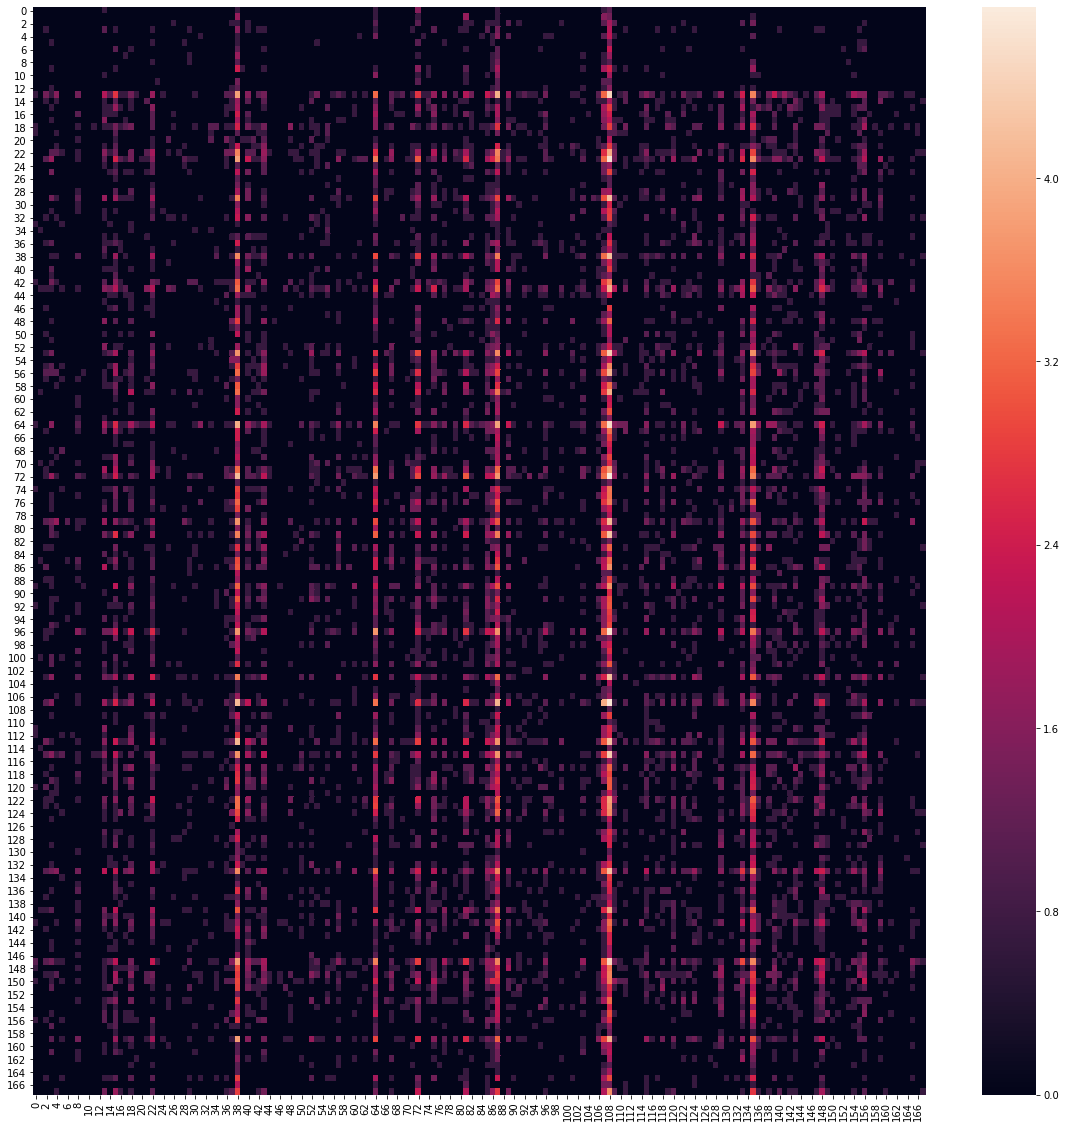

9.536938252322441 5.3284361598765955 2.250345587835903 1.9581565046099434


8.756554472977948 (5.058957420336973, 1.868591428182687, 1.8290056244582886)
0.011630960130506124
0.3344183347981018
0.25603622334212295
[[2206  506  255  203  580   35   18  407   13   22    3]
 [ 611 1280  277  311  160    4    2  673   32  274   38]
 [ 157   61 1620  283  138    7    0  212   28   37   34]
 [ 131   89  374  783   63    1    0   50   17   35   36]
 [ 297   66   73   42 1211   21    8  144    7    8    4]
 [ 137   25   13    5  262   23    4   50    1    2    0]
 [ 154   12    6    3  239   10    6   18    0    0    0]
 [ 233  311  190  123  166    1    0 1502   20  279   34]
 [  34   19  146   17   14    1    0   79    5   11    7]
 [  19  262   85   49   21    2    0  575   15  541   49]
 [   4   11   89   48    3    0    0   83    8   72   39]]
[[4187  223 2635   98 2607  851 1954]
 [  72   20  380    1   31   63  126]
 [ 171   48 1575    2  114  131  267]
 [  13    1   29    0    6    5    8]
 [ 452   20  148   14 1060  137  316]
 [ 447   53  460   13  543  277  4

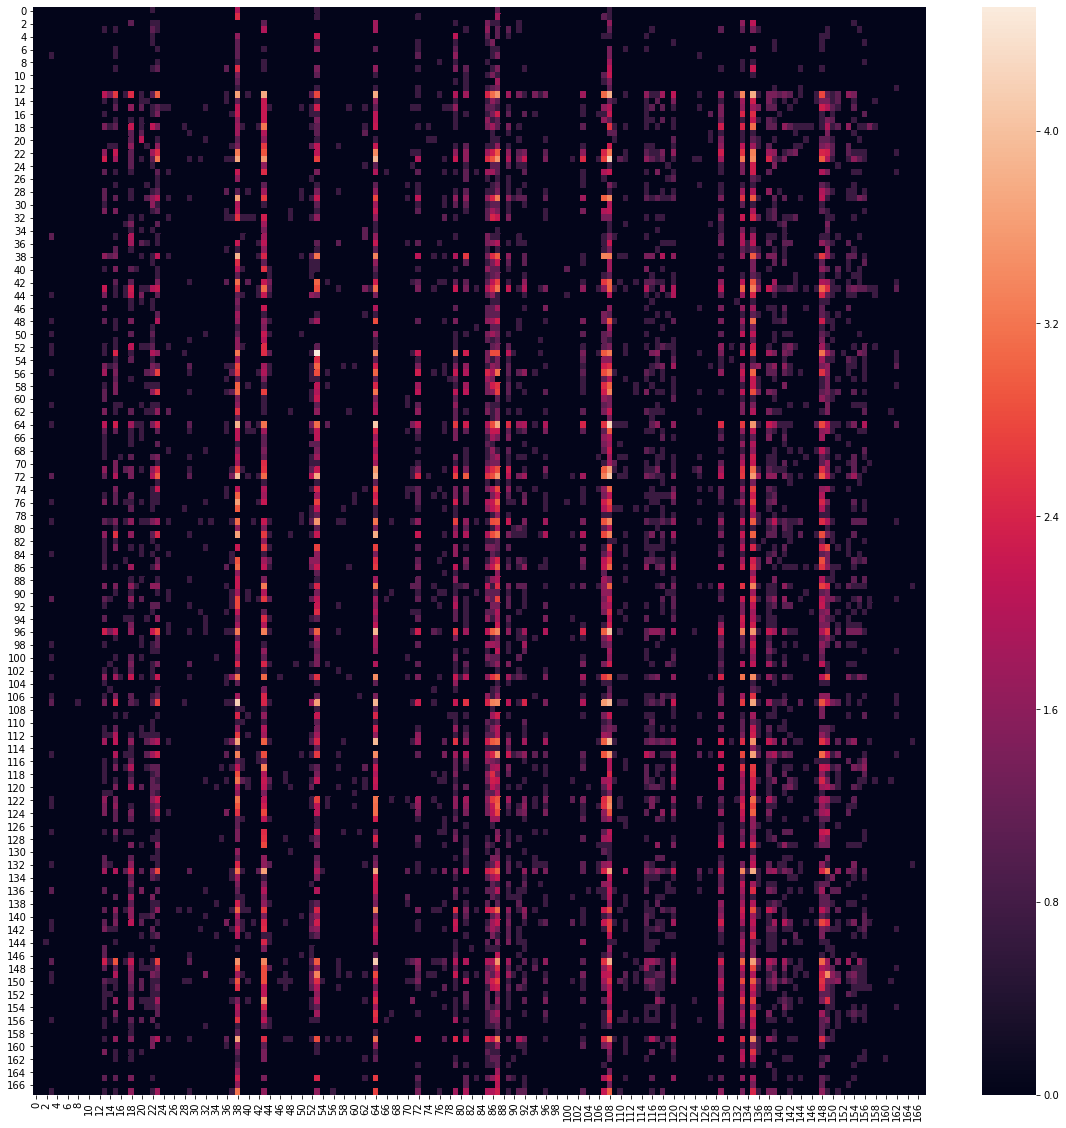

In [0]:
run_epochs(15)

In [0]:
for p in model.vowel_diac_predictor.parameters():
  p.requires_grad=False

for p in model.consonant_diacs.parameters():
  p.requires_grad=False


In [0]:
model.freeze()

2.836479634806118 1.3862035905025467 0.7409058206036848 0.7093702236998867


2.0304141111054994 (0.7859768081622519, 0.6487852458361607, 0.5956520571070871)
0.9343357836100574
0.9466212963308359
0.9720615683735946
[[4145   52    2    4   25   10    2    8    0    0    0]
 [ 101 3545    0    4    0    2    2    1    0    7    0]
 [   5    1 2570    1    0    0    0    0    0    0    0]
 [   3   57    0 1518    0    0    0    0    0    0    1]
 [  42    0    0    0 1831    3    3    2    0    0    0]
 [  12    1    0    0   20  483    6    0    0    0    0]
 [  23    0    0    0    2    7  416    0    0    0    0]
 [   7    1    8    0    0    0    0 2661    8  173    1]
 [   0    0    8    0    0    0    0   11  310    4    0]
 [   0    6    0    0    0    0    0    7    2 1601    2]
 [   0    1    0    0    0    0    0    0    1   58  297]]
[[11993    60   287     0    73   142     0]
 [    4   682     4     0     3     0     0]
 [   32    16  2240    18     0     2     0]
 [    0     0     0    62     0     0     0]
 [   37     0     4     3  2098     2     3]

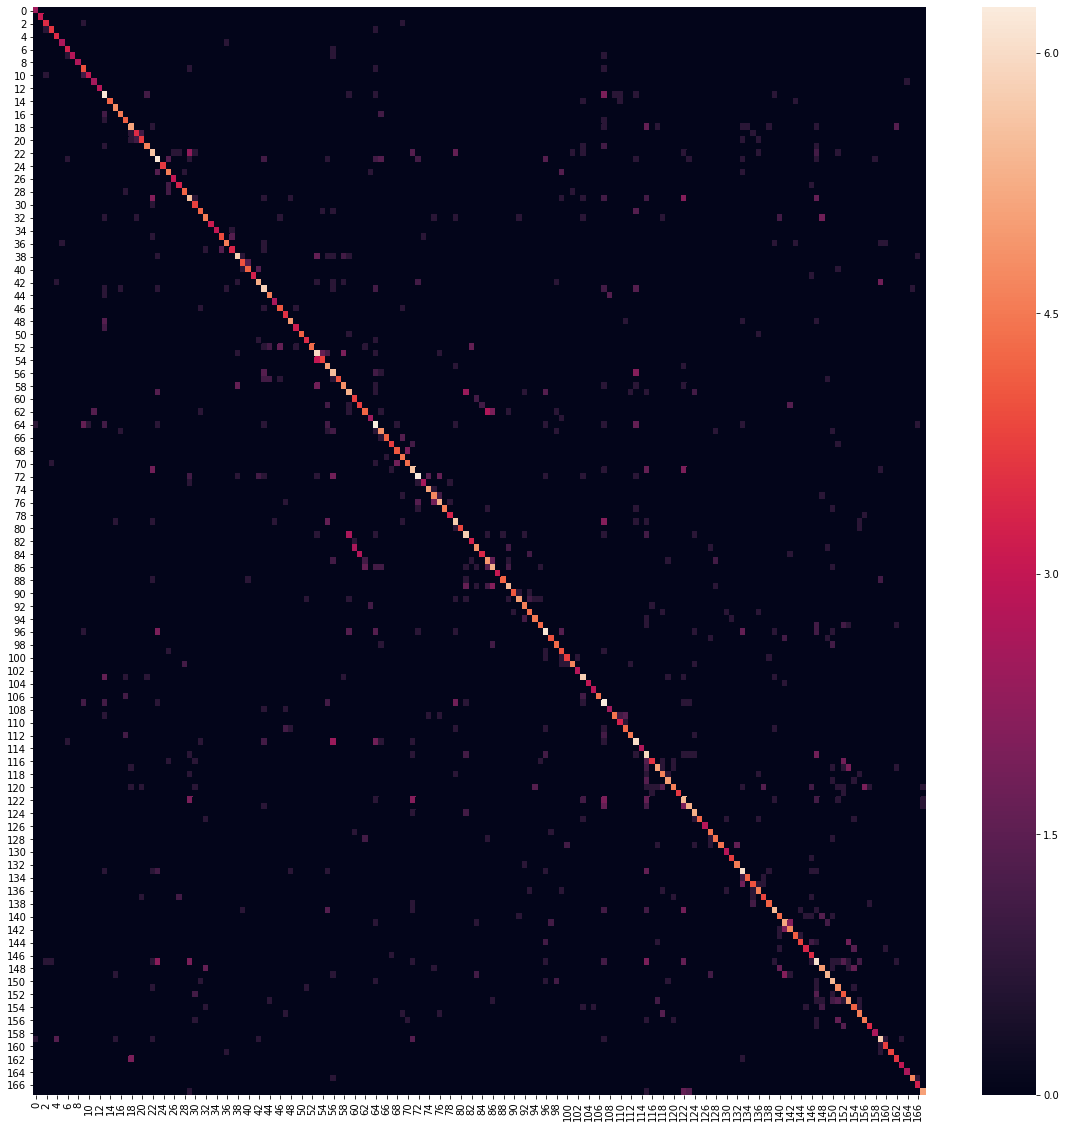

2.735518016135798 1.309273047101181 0.7304348737708235 0.6958100952637934


2.0133748196872174 (0.782469785137541, 0.6475026051329958, 0.5834024294166807)
0.9384398988616921
0.9502411870295991
0.9681869690945588
[[4123   52    3    5   37   10    4   13    0    1    0]
 [  91 3550    0    5    0    2    3    1    0   10    0]
 [   5    0 2570    1    0    0    0    0    0    1    0]
 [   4   46    0 1528    0    0    0    0    0    0    1]
 [  37    0    0    0 1835    3    4    2    0    0    0]
 [  11    0    0    0   21  482    8    0    0    0    0]
 [  19    0    0    0    3    5  421    0    0    0    0]
 [   6    0    8    0    0    0    0 2658   10  175    2]
 [   0    0    6    0    0    0    0   11  311    4    1]
 [   0    5    0    0    0    0    0    9    2 1599    3]
 [   0    1    0    0    0    0    0    0    1   49  306]]
[[12108    63   231     0    33   120     0]
 [    5   683     4     0     1     0     0]
 [   35    17  2250     3     0     3     0]
 [    0     0     1    61     0     0     0]
 [   72     0     6     2  2063     2     2]


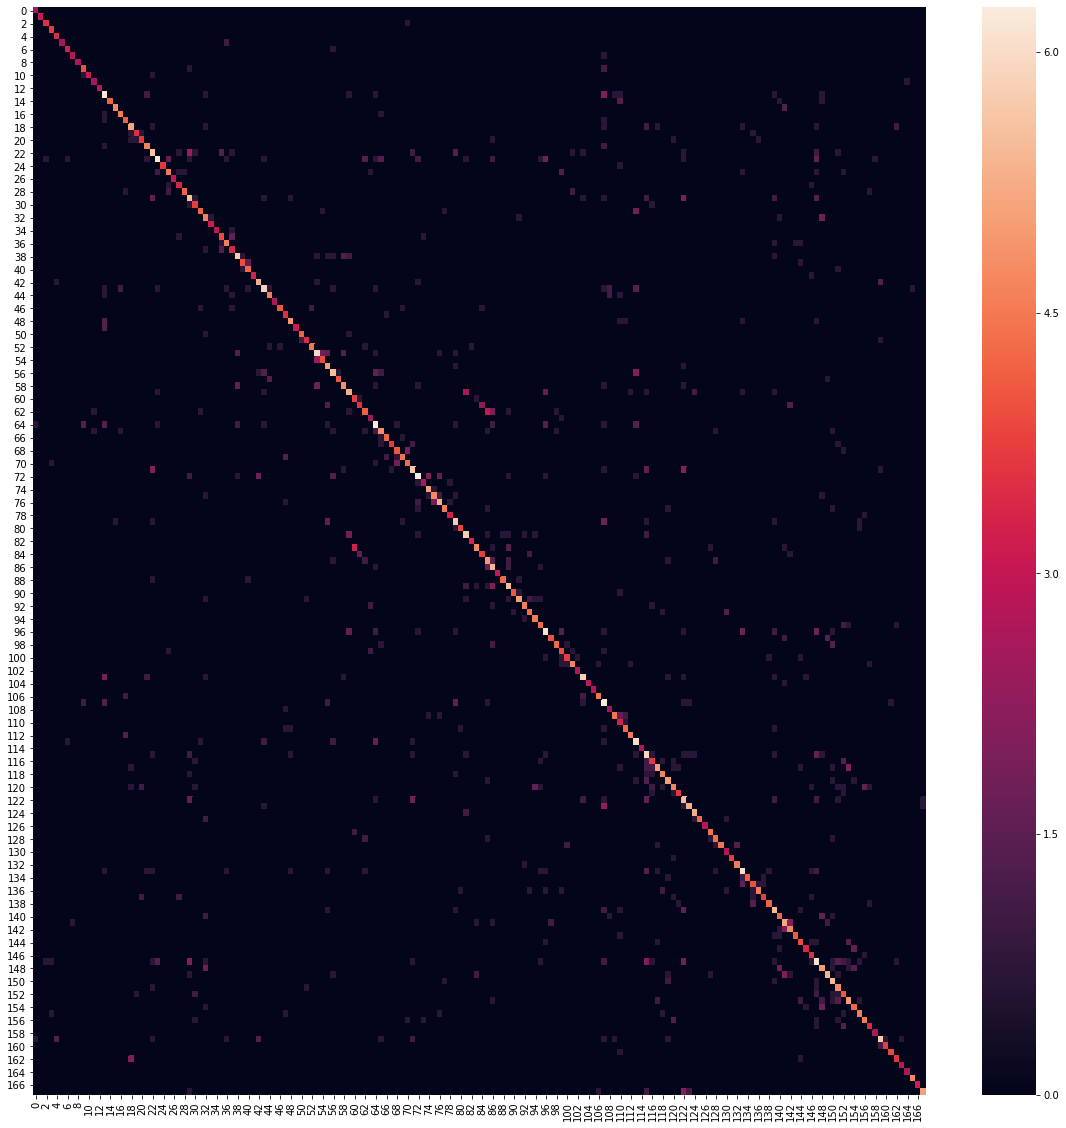

2.651599990347174 1.2448891379309583 0.721967865806957 0.6847429866092587


2.004595946354471 (0.776916690123309, 0.6479501866610946, 0.5797290695700675)
0.9395346963551412
0.9503942664639904
0.9721722437489035
[[4147   47    2    5   27    8    3    8    0    1    0]
 [ 103 3541    0    5    0    2    2    1    0    8    0]
 [   5    1 2570    1    0    0    0    0    0    0    0]
 [   3   46    0 1529    0    0    0    0    0    0    1]
 [  39    0    0    0 1834    3    3    2    0    0    0]
 [  13    0    0    0   20  481    8    0    0    0    0]
 [  24    0    0    0    2    3  419    0    0    0    0]
 [   7    1    8    0    0    0    0 2647   10  183    3]
 [   0    0    8    0    0    0    0   11  309    4    1]
 [   0    6    0    0    0    0    0    7    2 1600    3]
 [   0    1    0    0    0    0    0    0    1   44  311]]
[[12123    43   234     0    45   110     0]
 [    5   681     5     0     2     0     0]
 [   34    15  2250     7     0     2     0]
 [    0     0     0    62     0     0     0]
 [   57     0     5     2  2079     2     2]
 

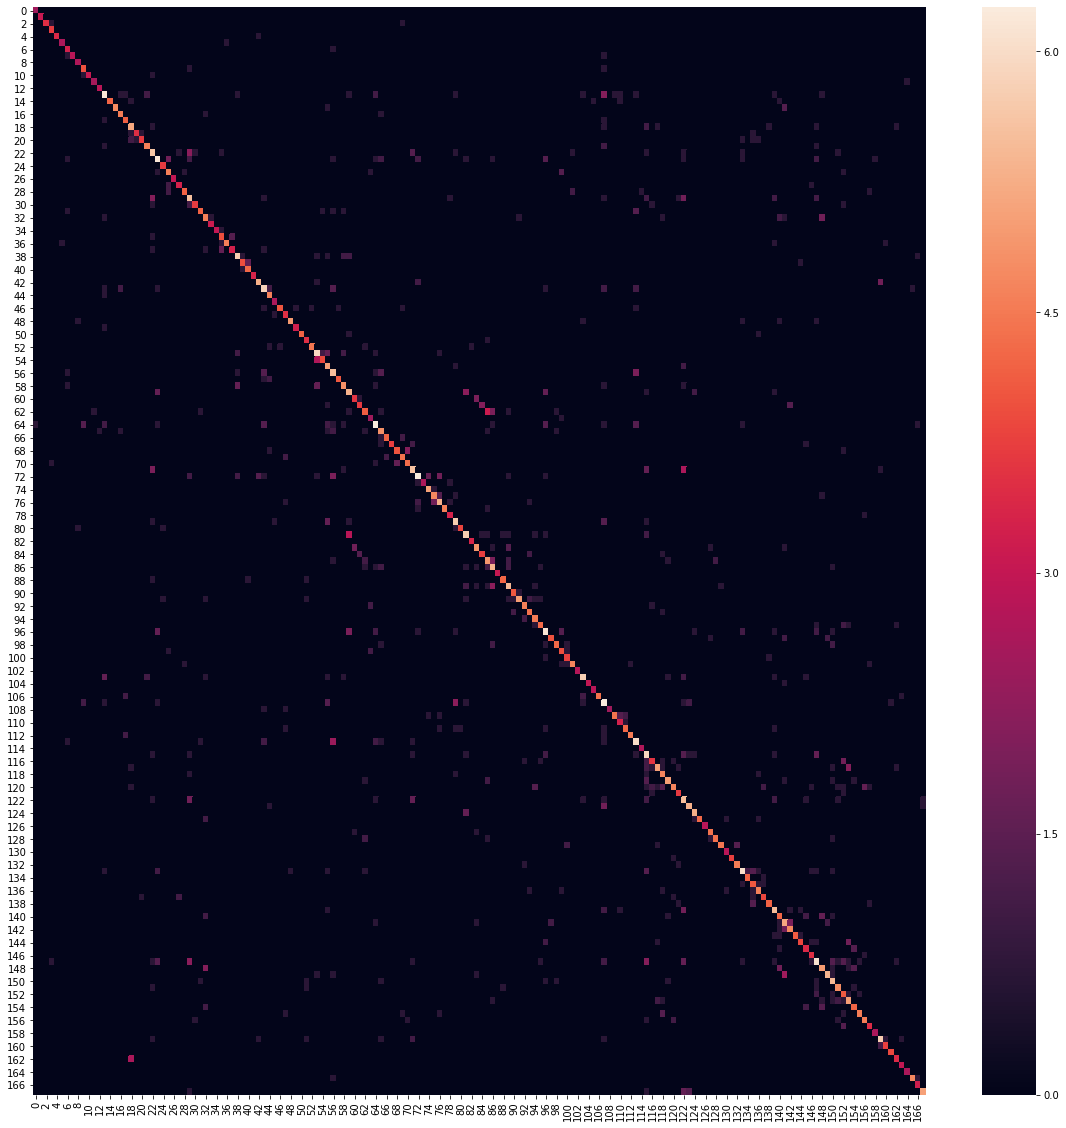

In [40]:
run_epochs(3)

In [0]:
plt.plot([sum(t) for t in tr_losses])

In [0]:
plt.plot([t[0] for t in tr_losses])

In [0]:
plt.plot([t[1] for t in tr_losses])

In [0]:
plt.plot([t[2] for t in tr_losses])

In [0]:
plt.plot([t[0] for t in va_losses])

In [0]:
plt.plot([t[1] for t in va_losses])

In [0]:
plt.plot([t[2] for t in va_losses])

In [0]:
torch.save(model.state_dict(), '/content/gdrive/My Drive/bhgd_r50_ls_p.pth')